# Elite Set Tracking

An elite set is a diverse pool of high quality solutions.  In GRASP we can track good solution as the algorithm executes.

## Imports

In [1]:
import numpy as np
import sys

## `meta_py` imports

In [2]:
# install metapy if running in Google Colab
if 'google.colab' in sys.modules:
    !pip install meta-py

In [3]:
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour

from metapy.tsp.objective import OptimisedSimpleTSPObjective

from metapy.local_search.hill_climbing import (HillClimber, TweakTwoOpt)

from metapy.tsp.grasp import (SemiGreedyConstructor,
                              FixedRCLSizer,
                              MonitoredLocalSearch,
                              GRASP)

## Load problem

In [4]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)
matrix = gen_matrix(cities, as_integer=True)

## Simple Implementation

Before we create a class that tracks an elite set during GRASP execution let's code a simple function  to simulate the basic mechanics.

The function `update_elite_set` is provided to illustrate a basic update operation to an elite set when a candidate solution **s** is provided.

In this example `elite_set` is a `numpy.ndarray` object where each element is a vector representing a tour.  The size of the array can grow up to `max_size`. The costs of the solutions are stored in the corresponding element in `elite_costs`.

### Initialisation

The elite pool of solution starts of empty.  Therefore the first solution pass to `update_elite_set` is added to the elite set.

### Behaviour while `len(elite_set) < max_size`

A solution **s** is only entered into `elite_set` if it sufficiently **diverse**: quantified as exceeding a hyper-parameter `min_delta`.  In this simple TSP example diversity, `delta`, is measured by the difference in the order of cities visited.  If `delta`

E.g. `a = [1, 2, 3, 4, 5]; b = [1, 3, 4, 2, 5]. delta = 3.`


### Behaviour while `len(elite_set) == max_size`

A solution **s** is only entered into `elite_set` when its is an improvement on **both** the **worst solution** in the pool and is **sufficiently diverse**.

> If **s** meets these criteria then it **replaces** the worst solution in the pool.


In [5]:
def update_elite_set(s, s_cost, elite_set=None, elite_costs=None, max_size=2, 
                     min_delta=0):
    '''
    Function to illustrate updating an elite set to maximise
    performance and diversity
    
    Params:
    -------
    s: np.ndarray
        TSP tour
        
    s_cost: float
        TSP tour cost
        
    elite_set: np.ndarray
        matrix of tours in elite set 
        
    elite_costs: np.ndarray
        vector of costs associate with each tour in elite set
        
    max_size:
        maximum entries in the elite set
        
    min_delta: int, optional (Default=0)
        The min cardinality difference between tours to allow entry
        E.g. a = [1, 2, 3, 4, 5]; b = [1, 3, 4, 2, 5]. delta = 3.
        Vary delta > 0 to increase diversity (but mauy limit entry)
        
    Returns:
    -------
    Tuple: np.ndarray, np.ndarray
        elite_set, elite_costs
        
    
    Example usage:
    --------------
    ```python
    >>  x = np.array([1, 2, 3, 4, 6, 7, 8])
    >> y = np.array([1, 4, 2, 6, 7, 3, 8])
    >> z = np.array([1, 5, 2, 6, 8, 3, 7])

    >> elite_set, elite_costs = update_elite_set(x, 10)
    >> elite_set, elite_costs = update_elite_set(y, 20, elite_set, elite_costs, max_size=2)
    >> print(elite_set)
    
    [[1 2 3 4 6 7 8]
     [1 4 2 6 7 3 8]]

    >> elite_set, elite_costs = update_elite_set(z, 15, elite_set, elite_costs, max_size=2)
    >> print(elite_set)
    
    [[1 5 2 6 8 3 7]
     [1 4 2 6 7 3 8]]
    ```
    '''
    
    if elite_set is None:
        # initalise elite_set
        elite_set = np.array([s])
        elite_costs = np.array([s_cost])
        return elite_set, elite_costs
        
    elif len(elite_set) < max_size:
        delta = (s != elite_set).sum(axis=1).min()
        if delta > min_delta:
            elite_set = np.append(elite_set, [s], axis=0)
            elite_costs = np.append(elite_costs, [s_cost], axis=0)
    else:
        # aim to increase performance and diversity of elite set
        worst_cost = elite_costs.min()
        delta = (s != elite_set).sum(axis=1).min()
        
        if s_cost > worst_cost and delta > min_delta:
            replace_idx = elite_costs.argmin()
            elite_set[replace_idx] = s
            elite_costs[replace_idx] = s_cost
            
    return elite_set, elite_costs

### Theoretical Example 

Let's create a very small elite pool of `max_size = 2` and `min_delta = 2`

We will pass `update_elite_set` the following 8 city tours in this order.

* [1, 2, 3, 4, 6, 7, 8]; cost = -10.0
* [1, 4, 2, 6, 7, 3, 8]; cost = -20.0
* [1, 5, 2, 6, 8, 3, 7]; cost = -15.0
* [1, 7, 2, 6, 8, 3, 5]; cost = -14.0

In [6]:
# example script
x = np.array([1, 2, 3, 4, 6, 7, 8])
y = np.array([1, 4, 2, 6, 7, 3, 8])
z = np.array([1, 5, 2, 6, 8, 3, 7])
redundant = np.array([1, 7, 2, 6, 8, 3, 5])

# initialse set
elite_set, elite_costs = update_elite_set(x, -10.0)
print(elite_set)

[[1 2 3 4 6 7 8]]


In [7]:
# len(elite_set) < max_size
# is y eligible for addition to the elite set?
# this will work as it has 5 elements different from x
print(f'evaluating: {y}')
elite_set, elite_costs = update_elite_set(y, -20.0, elite_set, elite_costs, max_size=2,
                                          min_delta=3)
print(elite_set)

evaluating: [1 4 2 6 7 3 8]
[[1 2 3 4 6 7 8]
 [1 4 2 6 7 3 8]]


In [8]:
# len(elite_set) == max_size
# is z eligible for addition to the elite set?
# it is compared to y because that has the 'worst' value
# this will work as it has 3 elements different from its most similar neighbour
print(f'evaluating: {z}')
elite_set, elite_costs = update_elite_set(z, -15.0, elite_set, elite_costs, max_size=2,
                                          min_delta=2)
print(elite_set)

evaluating: [1 5 2 6 8 3 7]
[[1 2 3 4 6 7 8]
 [1 5 2 6 8 3 7]]


In [9]:
# is redundant eligible for addition to the elite set?
# it is compared to y because that has the 'worst' value
# this will NOT work as it has only 2 elements different from its most similar neighbour
print(f'evaluating: {redundant}')
elite_set, elite_costs = update_elite_set(redundant, -14.0, elite_set, 
                                          elite_costs, max_size=2,
                                          min_delta=2)
print(elite_set)

evaluating: [1 7 2 6 8 3 5]
[[1 2 3 4 6 7 8]
 [1 5 2 6 8 3 7]]


## An implementation to work within GRASP

* The class `EliteSet` which, if provided, tracks a `GRASP` objects `MonitoredLocalSearch` and updates an elite set after each iteration.

In [10]:
class EliteSet:
    '''
    Tracks and updates an elite set of solutions produced by a local search.
    '''
    def __init__(self, local_search=None, max_size=10, min_delta=0):
        '''
        Constructor
        Params:
        -------
        local_search: MonitoredLocalSearch
            The local search that produces candidates for the elite
            set.
        
        max_size: int, optional (default=10)
            maximum entries in the elite set

        min_delta: int, optional (Default=0)
            The min cardinality difference between tours to allow entry
            E.g. a = [1, 2, 3, 4, 5]; b = [1, 3, 4, 2, 5]. delta = 3.
            Vary delta > 0 to increase diversity (but may limit entry)
        '''
        if local_search is not None:
            self.local_search = local_search
            local_search.register_observer(self)
        
        self.min_delta = min_delta
        self.max_size = max_size
        
        # data structures for elite solutions
        self.solutions = None
        self.costs = None
        
        self.n_updates = 0
    
    @property
    def is_empty(self):
        return self.solutions is None
    
    def is_elite(self, solution):
        '''
        Is the solution a member of the elite set
        
        Params:
        ------
        solution: np.ndarray
            TSP solutution
            
        Returns:
        --------
        bool
        '''
        if self.solutions is None:
            return False
        else:
            result = np.where((self.solutions==solution).all(axis=1))[0]
            return len(result) > 0
    
    def local_search_terminated(self, *args, **kwargs):
        ''''
        Termination of the local search
        '''
        s = args[1]
        s_cost = args[0]
        self.update(s, s_cost)
            
    def init_elite_set(self, s, s_cost):
        '''
        Initalise the elite set
        '''
        self.solutions = np.array([s])
        self.costs = np.array([s_cost])
    
    def update(self, s, s_cost):
        '''
        Update the elite set to maximise performance and diversity

        Params:
        -------
        s: np.ndarray
            TSP tour

        s_cost: float
            TSP tour cost

        Returns:
        -------
        Tuple: np.ndarray, np.ndarray
            elite_set, elite_costs
        '''
        if self.solutions is None:
            self.init_elite_set(s, s_cost)
        
        elif len(self.solutions) < self.max_size:
            delta = (s != self.solutions).sum(axis=1).min()
            if delta > self.min_delta:
                self.solutions = np.append(self.solutions, [s], axis=0)
                self.costs = np.append(self.costs, [s_cost], axis=0)
        else:
            # aim to increase performance and diversity of elite set
            worst_cost = self.costs.min()
            delta = (s != self.solutions).sum(axis=1).min()

            if s_cost > worst_cost and delta > self.min_delta:
                replace_idx = self.costs.argmin()
                self.solutions[replace_idx] = s
                self.costs[replace_idx] = s_cost
                self.n_updates += 1
                
    def get_best_solution(self):
        '''Returns the best solution and cost
        from the elite set'''
        best_idx = np.array(self.costs).argmax()
        return self.solutions[best_idx], self.costs[best_idx]

In [11]:
def compose_grasp(tour, matrix, max_iter=50, rcl_size=5, 
                  set_size=10, random_seed=None):
    '''
    Compose the GRASP algorithm and track the elite set.
    '''
    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search = first improvement hill climbing
    ls = MonitoredLocalSearch(HillClimber(obj, tour, tweaker))

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(rcl_size)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, 
                                        random_seed=random_seed)

    # elite set tracker
    tracker = EliteSet(ls, max_size=set_size)

    # GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver, tracker


Running GRASP with Elite Set Tracking.

** GRASP OUTPUT ***
best cost:	-724.0
Elite set costs: [-776. -796. -802. -798. -773. -778. -753. -724. -795. -776. -758. -749.
 -794. -793. -787.]
best solution:
[ 0 35 22 15 46 36 57  4 52  5 40 41 17  3  1  6 31  2 43 67 42 16 59 51
  9 49 50 64 63 10 55 66 47 53 61 32 11 20 33  8 39 60 38 44 24 45 26 29
 19 13 27  7 25 48 54 18 23 14 56 65 21 62 58 37 68 30 12 69 34 28]


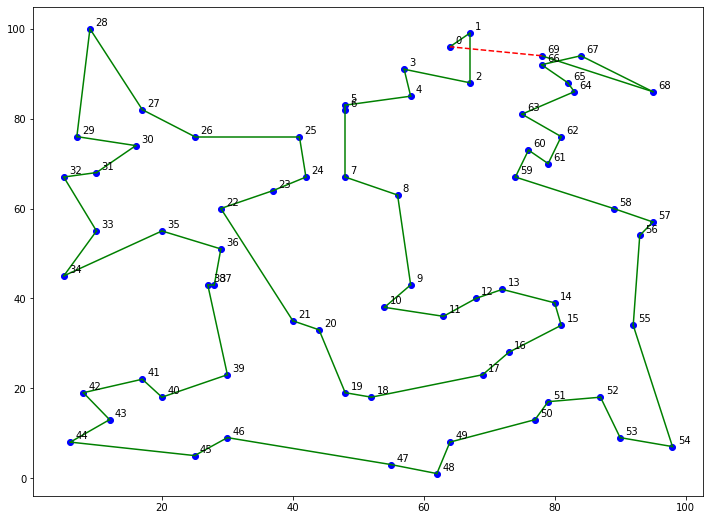

In [12]:
tour = np.arange(len(cities))
solver, tracker = compose_grasp(tour, matrix, set_size=15, random_seed=101)
print("\nRunning GRASP with Elite Set Tracking.")
solver.solve()

print("\n** GRASP OUTPUT ***")
print("best cost:\t{0}".format(solver.best))
print(f'Elite set costs: {tracker.costs}')

print("best solution:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))

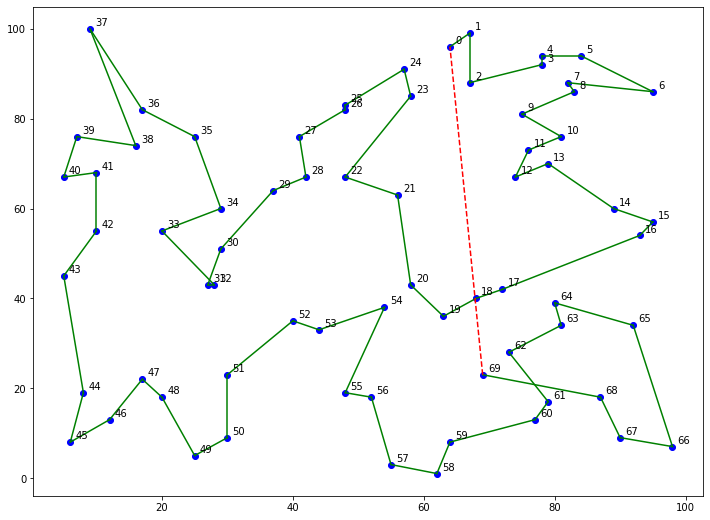

In [13]:
# one of the 'elite' set
fig, ax = plot_tour(tracker.solutions[2], cities, figsize=(12,9))